In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Paths to your dataset
base_dir = '/kaggle/input/corndata/archive/train'

# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32
seed = 123  # Ensure reproducibility
validation_split = 0.2  # 20% of data used for validation

# Load the training dataset
train_generator = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="training",
    interpolation="bilinear"
)

# Load the validation dataset
val_generator = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="validation",
    interpolation="bilinear"
)

# Load the DenseNet121 model with pre-trained weights, excluding the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling instead of Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Add more layers
x = Dense(16, activation='relu')(x)  # Additional dense layer with fewer units
x = Dropout(0.2)(x)  # Dropout to prevent overfitting
x = BatchNormalization()(x)  # Normalize output
x = Dense(8, activation='relu')(x)  # Further reduce the dimensionality
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Final output layer with softmax
predictions = Dense(4, activation='softmax')(x)  # 4 classes (modify if needed)


# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Calculate the number of layers to unfreeze
total_layers = len(base_model.layers)
unfreeze_layers = int(0.20 * total_layers)  # Unfreeze the last 20% of layers

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20% of layers
for layer in base_model.layers[-unfreeze_layers:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # Increased epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')



Found 17864 files belonging to 4 classes.
Using 14292 files for training.
Found 17864 files belonging to 4 classes.
Using 3572 files for validation.
Epoch 1/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.2703 - loss: 1.6839 - val_accuracy: 0.3950 - val_loss: 1.3268 - learning_rate: 1.0000e-04
Epoch 2/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2931 - loss: 1.5535 - val_accuracy: 0.4787 - val_loss: 1.2485 - learning_rate: 1.0000e-04
Epoch 3/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3196 - loss: 1.4662 - val_accuracy: 0.5291 - val_loss: 1.2017 - learning_rate: 1.0000e-04
Epoch 4/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3416 - loss: 1.4079 - val_accuracy: 0.5795 - val_loss: 1.1436 - learning_rate: 1.0000e-04
Epoch 5/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3924 - loss: 1.3369 - val_accuracy: 0.6184 - val_loss: 1.0979 - learning_rate: 1.0000e-04
Epoch 6/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accu

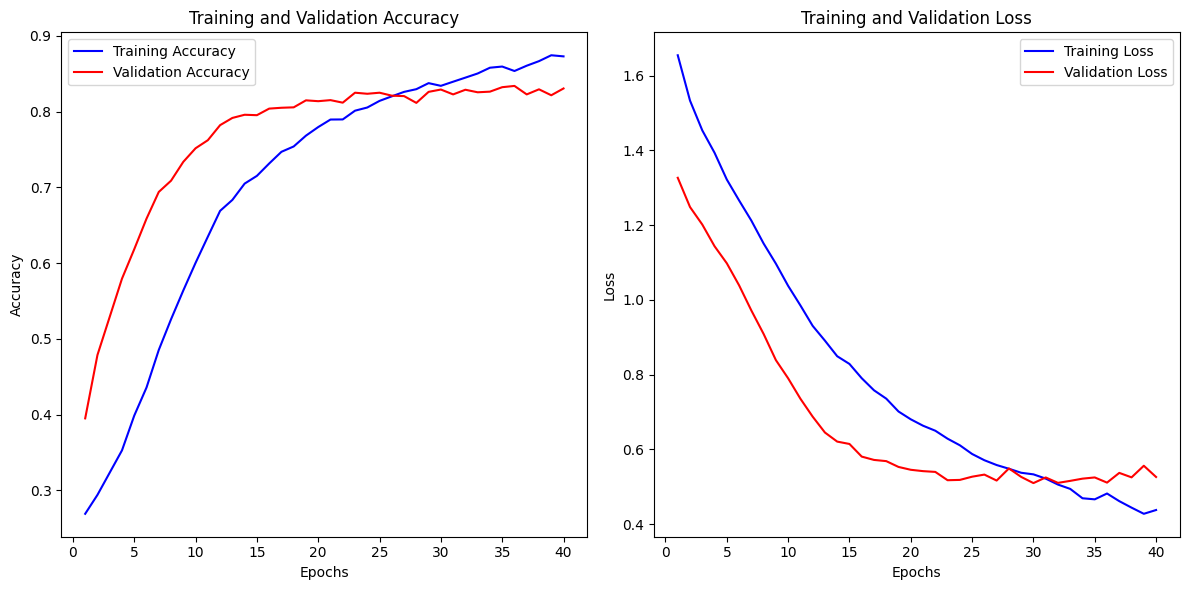

In [8]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


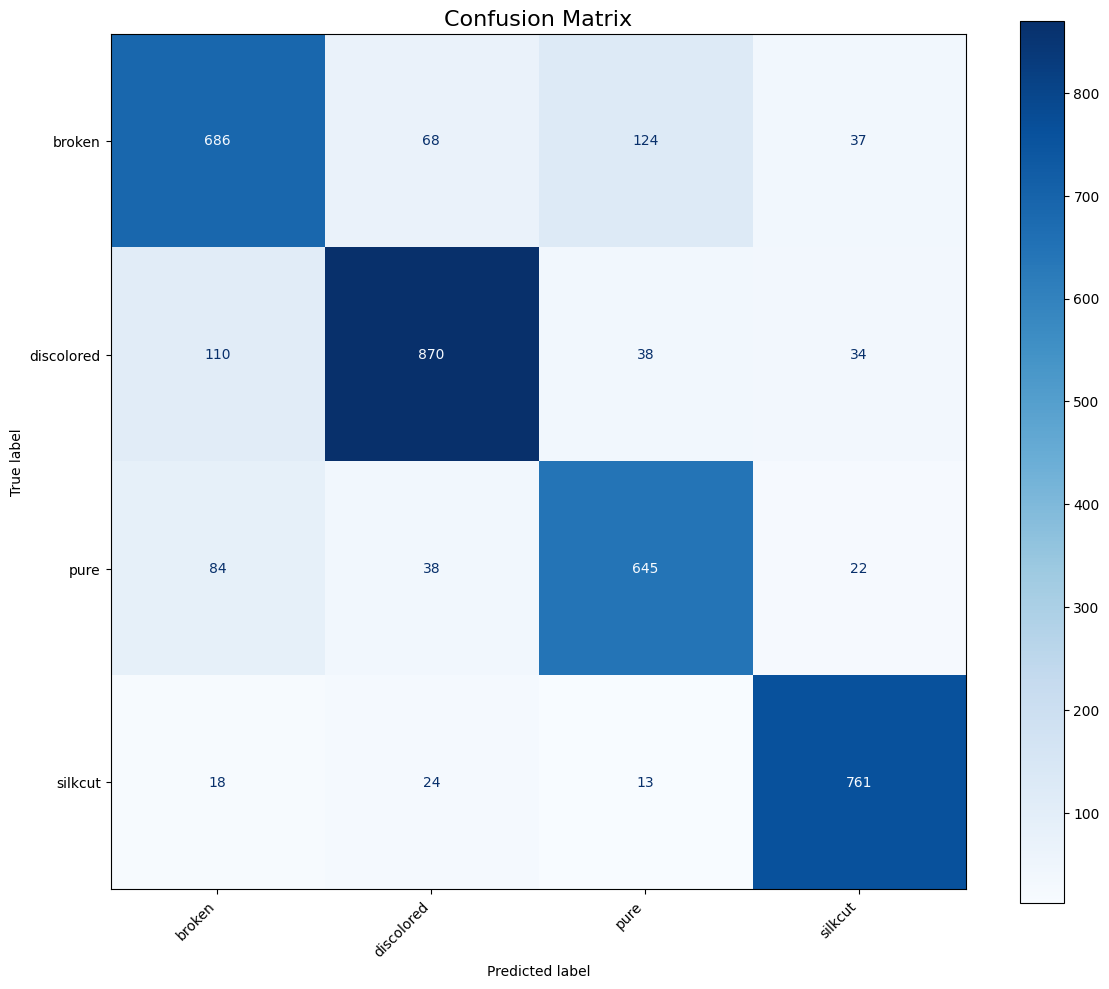

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predicted labels for the validation data
true_labels = []
predicted_labels = []

# Iterate through the validation data to get true and predicted labels
for images, labels in val_generator:
    # True labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicted labels
    preds = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = val_generator.class_names  # Class names inferred from the dataset
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Create a figure for better layout
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, colorbar=True, ax=ax)

# Rotate and align x-axis labels to avoid overlapping
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()  # Automatically adjusts layout for readability
plt.show()


In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predicted labels for the validation data
true_labels = []
predicted_labels = []

# Iterate through the validation data to get true and predicted labels
for images, labels in val_generator:
    # True labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicted labels
    preds = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Class names
class_names = val_generator.class_names  # Inferred from the dataset

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      broken       0.82      0.85      0.86       915
  discolored       0.87      0.83      0.85      1052
        pure       0.84      0.82      0.80       789
     silkcut       0.81      0.83      0.81       816

    accuracy                           0.83      3572
   macro avg       0.83      0.83      0.83      3572
weighted avg       0.83      0.83      0.83      3572

